In [ ]:
from subtract_psf import KlipRetrieve, PreInjectImages

In [ ]:
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import time

# Load tables.

### Original instructions

<blockquote>

*Here is the full resolution planet flux and wavelength. The flux units are in ~~ergs/s/cm^2/cm~~ **ergs/s/cm^2/cm/sr** and the wavelength is in **micron**, so you should have way more than you need (it goes out to 900 microns). (file: 2048_377_6micron.txt). (ignore the 6micron title part, you have the full res, full wavelength file)*

*Also attached is the star, this is high resolution as well. The flux is in the same units (**ergs/s/cm^2/cm/sr**), the wavelengths are in **Angstroms** for the star and it goes out to about 5.5 microns or 55000 Angstroms. (kappa_star_model.txt) This should be enough for NIRSpec.*
</blockquote>

### Flux/radiance refresher

Different types of flux are often confusingly named, so I did a small review.

**Spectral radiance/spectral brightness/specific intensity** is the power *emitted* by a surface per unit projcted area *and* per unit solid angle. This means:
- Planck's Law blackbody specific intensity, per unit wavelength, is: $W\, /\, sr\, /\, m^3$.
- Planck's Law blackbody specific intensity, per unit frequency, is: $W\, /\, sr\, /\, m^2\, /\, Hz$.

*(`astropy`'s deprecated [`blackbody_lambda`](https://docs.astropy.org/en/stable/api/astropy.modeling.blackbody.blackbody_lambda.html) and [`blackbody_nu`](https://docs.astropy.org/en/stable/api/astropy.modeling.blackbody.blackbody_nu.html) methods, respectively, return values in these units. The new [`BlackBody`](https://docs.astropy.org/en/stable/api/astropy.modeling.physical_models.BlackBody.html) class can return either unit.)*
<br>
_[to convert between different forms of blackbody specific intensity:
$\frac{B(\lambda, T)}{B(\nu, T)} = c / \lambda^2 = \nu^2 / c$ (given that $\lambda = c / \nu$) ]_

**Spectral irradiance/flux density** is the power *received* by surface per unit area.
- flux density units per unit wavelength are $W\, /\, m^3$.
- flux density units per unit frequency are $W\, /\, m^2\, /\, Hz$.

*(`astropy`'s deprecated [`BlackBody1D`](https://docs.astropy.org/en/stable/api/astropy.modeling.blackbody.BlackBody1D.html) class returns flux densities in these units.)*
<br>
*(Janskys, which are used later on in the notebook, are a unit of flux density.)*

We use flux densities to measure contrast. Since the Kappa And files contain specific intensities, we need to get rid of the "per unit solid angle" by multiplying both intensity columns by the projected area of their respective object on the sky.

[Additional](https://en.wikipedia.org/wiki/Radiant_intensity#SI_radiometry_units) [links](www.cv.nrao.edu/course/astr534/Brightness.html) [of](https://en.wikipedia.org/wiki/Planck's_law#The_law) [interest](https://en.wikipedia.org/wiki/Planck's_law#Correspondence_between_spectral_variable_forms).

In [ ]:
flux_units = u.erg / u.s / u.cm**3

In [ ]:
# save Kappa And system information
rad_kapA = (2.31 * 696.34 * 1e6 * u.m).to(u.solRad)
rad_kapb = (1.2 * 69.911 * 1e6 * u.m).to(u.jupiterRad)
dist_kap = (1.5922e18 * u.m).to(u.pc)
sep_au = 55 * u.AU
rad_kapA, rad_kapb, dist_kap, sep_au

(<Quantity 2.31212505 solRad>,
 <Quantity 1.17346277 jupiterRad>,
 <Quantity 51.59968785 pc>,
 <Quantity 55. AU>)

In [ ]:
# get kappa and b's separation in arcseconds
print(f"distance is {dist_kap:.2f}; separation in physical units is {sep_au:.2f}.")

sep_arc = np.arctan(sep_au / dist_kap).to(u.arcsec)
print(f"this means the apparent separation is {sep_arc:.3f}.")
sep_arc = sep_arc.value

distance is 51.60 pc; separation in physical units is 55.00 AU.
this means the apparent separation is 1.066 arcsec.


In [ ]:
# load Kappa And A
#new_star = Table.read('/Users/jotor/repositories/subtract-psf/real_spectra/kappa_star_model.txt', format='ascii')
new_star = Table.read('/user/jotor/gen_images/real_spectra/kappa_star_model.txt', format='ascii')
# copy this directory to a local location like I did in the commented line for faster loading

In [ ]:
# order and name columns for proper reading in KlipRetrieve
new_star.rename_column('col2', 'wavelength')
new_star.rename_column('col1', 'flux')
new_star = new_star[new_star.colnames[::-1]]

In [ ]:
# assign units to columns following original instructions
new_star['wavelength'].unit = u.angstrom
new_star['wavelength'] = new_star['wavelength'].to(u.micron) # change to match other table
new_star['flux'].unit = u.erg / u.s / u.cm**2 / u.cm / u.sr

In [ ]:
# scale and multiply out steradians to get a true flux density
new_star['flux'] = (new_star['flux'] * np.pi * (rad_kapA / dist_kap * u.rad)**2).to(flux_units)

In [ ]:
# load Kappa And b
#new_comp = Table.read('/Users/jotor/repositories/subtract-psf/real_spectra/2048_377_6micron.txt', format='ascii')
new_comp = Table.read('/user/jotor/gen_images/real_spectra/2048_377_6micron.txt', format='ascii')
# copy this directory to a local location like I did in the commented line for faster loading

In [ ]:
# order and name columns for proper reading in KlipRetrieve
new_comp.rename_column('col2', 'wavelength')
new_comp.rename_column('col1', 'flux')
new_comp = new_comp[new_comp.colnames[::-1]]

In [ ]:
# assign units to columns following original instructions
new_comp['wavelength'].unit = u.micron
new_comp['flux'].unit = u.erg / u.s / u.cm**2 / u.cm / u.sr

In [ ]:
# scale and multiply out steradians to get a true flux density
new_comp['flux'] = (new_comp['flux'] * np.pi * (rad_kapb / dist_kap * u.rad)**2).to(flux_units)

In [ ]:
# choose a wavelength range to plot
#wv_lo = 1 * u.micron
wv_lo = 2.87 * u.micron # from nirspec
wv_hi = 5.27 * u.micron # from nirspec

# limit tables to entries with wavelengths between these two values
star_entries = np.argwhere((new_star['wavelength'].quantity >= wv_lo)
                           & (new_star['wavelength'].quantity <= wv_hi)).flatten()

comp_entries = np.argwhere((new_comp['wavelength'].quantity >= wv_lo)
                           & (new_comp['wavelength'].quantity <= wv_hi)).flatten()

In [ ]:
# get astropy quantity arrays for wavelengths and flux densities to be plotted
wv_star_plot = new_star['wavelength'][star_entries].quantity
wv_comp_plot = new_comp['wavelength'][comp_entries].quantity

scaled_star_flux = new_star['flux'][star_entries].quantity
scaled_comp_flux = new_comp['flux'][comp_entries].quantity

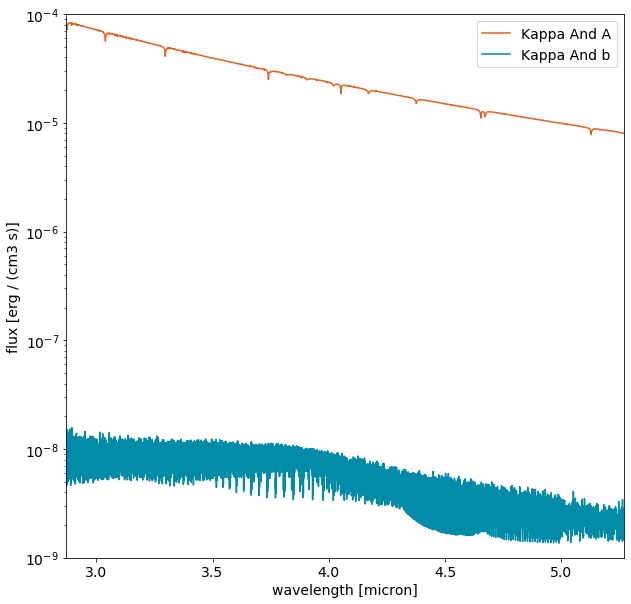

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
                       
plt.semilogy(wv_star_plot, scaled_star_flux, label='Kappa And A', c='#e56020')
plt.semilogy(wv_comp_plot, scaled_comp_flux, label='Kappa And b', c='#008ca8')
plt.legend(fontsize=14)

# get orders of magnitude of lowest comp/highest star flux density values
# and use them to set y limits
plt.ylim(10**(np.floor((np.log10(scaled_comp_flux.min().value))) - 0),
         10**(np.floor((np.log10(scaled_star_flux.max().value))) + 1))
plt.xlim(wv_lo.value, wv_hi.value)

plt.xlabel(f"wavelength [{wv_comp_plot.unit}]", fontsize=14)
plt.ylabel(f"flux [{scaled_star_flux.unit}]", fontsize=14)
ax.tick_params(labelsize=14)
#plt.savefig('kappa_and_spectra.png', dpi=300)

*Helpful rule of thumb: `magnitude difference = -2.5 * contrast order of magnitude`*.

For example, two objects with a contrast of $10^{-4}$ are about `-2.5 * 4 =` 10 magnitudes apart from each other.
<br>
Or, two objects that are 5 magnitudes apart, since `5 / -2.5 = 2`, have a contrast of about $10^{-2}$.

# Pre-inject a set of simulated data cubes.

In this section, we use the edited spectra from above (`new_star` and `new_comp`) to inject a synthetic companion into the target images of all data cubes in an already existing directory of "observations" generated by `CreateImages()`. The "pre" refers to the fact that this will happen before any of the alignment or subtraction steps shown in [introduction.ipynb](introduction.ipynb).

`subtract_psf` has a special class for this process called `PreInjectImages()`. We'll try it on a full, 3610 slice set of data cubes to give an idea of how a real application of the class looks. Cells that can take some time to execute have timers to give an idea of how long they usually run.

*(if you've imported `subtract_psf` and are curious about any of the methods mentioned, put your cursor on it and press `Shift`+`Tab` a couple of times to view the docstrings.)*

In [ ]:
start = time.time()

#pre_full0 = PreInjectImages('/Users/jotor/gen_images_copy/_all_slices_4_os0/')
pre_full0 = PreInjectImages('/user/jotor/gen_images/_all_slices_4_os0')
# copy this directory to a local location like I did in the commented line to get speeds like below

print(f"{time.time() - start:.3f} s")

7.474 s


In [ ]:
start = time.time()

# receive an injected version of the target cubes along with
# the binned milliJansky fluxes from the stellar and companion spectra
(pre_full0.injected_cubes,
 star_fluxes_full,
 comp_fluxes_full) = pre_full0.inject_companion(pre_full0.data_cubes, star_spectrum=new_star,
                                                comp_spectrum=new_comp, separation=sep_arc,
                                                position_angle=np.rad2deg(-np.pi/4),
                                                return_fluxes=True)

print(f"{(time.time() - start) / 60:02.0f}:{(time.time() - start) % 60:06.3f}")
# minutes : seconds

********
injecting companion with spectrally defined intensity into unaligned images.
********
01:51.485


In [ ]:
# convert returned flux density arrays from Janskys to units from first section
binned_st_fluxes = star_fluxes_full.to(flux_units,
                                       u.spectral_density(pre_full0.wvlnths * u.m))
binned_cp_fluxes = comp_fluxes_full.to(flux_units,
                                       u.spectral_density(pre_full0.wvlnths * u.m))

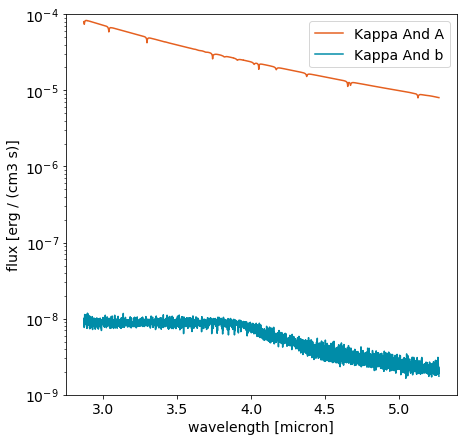

In [ ]:
# plot binned down versions of spectra used for injection above
fig, ax = plt.subplots(figsize=(7,7))

plt.semilogy((pre_full0.wvlnths * u.m).to(u.micron), binned_st_fluxes,
             label='Kappa And A', c='#e56020')
plt.semilogy((pre_full0.wvlnths * u.m).to(u.micron), binned_cp_fluxes,
             label='Kappa And b', c='#008ca8')
plt.legend(fontsize=14)

plt.ylim(10**(np.floor((np.log10(binned_cp_fluxes.min().value))) - 0),
         10**(np.floor((np.log10(binned_st_fluxes.max().value))) + 1))
plt.xlabel(f"wavelength [{u.micron}]", fontsize=14)
plt.ylabel(f"flux [{flux_units}]", fontsize=14)

ax.tick_params(labelsize=14)

We can then export an HDUList that includes these injected cubes (`pre_full0.injected_cubes`) to a new directory, remembering to include the uninjected reference cubes from `pre_full0.data_cubes` as its first half.

In [ ]:
import os

def parent_dir(base_path):
    return os.path.realpath(os.path.join(base_path, os.pardir)) + '/'

inj_dir_path = parent_dir(pre_full0.dir_name) + 'inj_kappa_all_slices0'

In [ ]:
all_cubes = pre_full0.data_cubes[:len(pre_full0.positions)] + pre_full0.injected_cubes
fits.HDUList(all_cubes).info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  REFERENCE0    1 ImageHDU      3721   (30, 30, 3610)   float64   
  1  REFERENCE1    1 ImageHDU      3721   (30, 30, 3610)   float64   
  2  REFERENCE2    1 ImageHDU      3721   (30, 30, 3610)   float64   
  3  REFERENCE3    1 ImageHDU      3721   (30, 30, 3610)   float64   
  4  REFERENCE4    1 ImageHDU      3721   (30, 30, 3610)   float64   
  5  REFERENCE5    1 ImageHDU      3721   (30, 30, 3610)   float64   
  6  REFERENCE6    1 ImageHDU      3721   (30, 30, 3610)   float64   
  7  REFERENCE7    1 ImageHDU      3721   (30, 30, 3610)   float64   
  8  REFERENCE8    1 ImageHDU      3721   (30, 30, 3610)   float64   
  9  REFERENCE9    1 ImageHDU      3721   (30, 30, 3610)   float64   
 10  TARGET0       1 ImageHDU      7335   (30, 30, 3610)   float64   
 11  TARGET1       1 ImageHDU      7335   (30, 30, 3610)   float64   
 12  TARGET2       1 ImageHDU      7335   (30, 30

In [ ]:
start = time.time()

pre_full0.export_to_new_dir(all_cubes, inj_dir_path)

print(f"{(time.time() - start) / 60:02.0f}:{(time.time() - start) % 60:06.3f}")

00:08.805


# Subtract the background star from the injected data cubes.

Next, we use the `KlipRetrieve` class from `subtract_psf` on this new directory of injected images. Once initialized, it performs a few steps to subtract the background star from the target images.

- It aligns all data cube images (both reference and target) so the star is in nearly the same spot in all of them.
- Next, it makes KLIP projections of the target images by using the reference images to calculate a PCA basis.
- Then, it subtracts each projection by its corresponding target image, hopefully leaving a set of data cubes with only the companion in each slice.

_(Note that the star is scaled to have the same brightness in all slices, so the companion's brightness is influenced by changes in both its own flux *and* the star's.)_

In [ ]:
start = time.time()

kr_full0 = KlipRetrieve(inj_dir_path)

print(f"{(time.time() - start) / 60:02.0f}:{(time.time() - start) % 60:06.3f}")

in /Users/jotor/gen_images_copy/inj_kappa_all_slices0...
********
aligning all data cubes' images by their bright pixels...
********
********
removing padding from alignment process...
********
********
generating KLIP projections of target images in `self.klip_proj`...
********
********
generating pre-/post-subtraction contrast curves...
********
********
completed `self.pre_prof_hdu`, `self.post_prof_hdu`, `self.photon_prof_hdu`, and `self.pre_avg_hdu`.
********
03:23.146



********
total intensity pre-subtract:  9.4214e-01
total intensity post-subtract: 4.8300e-03
********


/Users/jotor/miniconda3/envs/astroconda2/lib/python3.7/site-packages/astropy/visualization/stretch.py:386: RuntimeWarning:overflow encountered in sinh

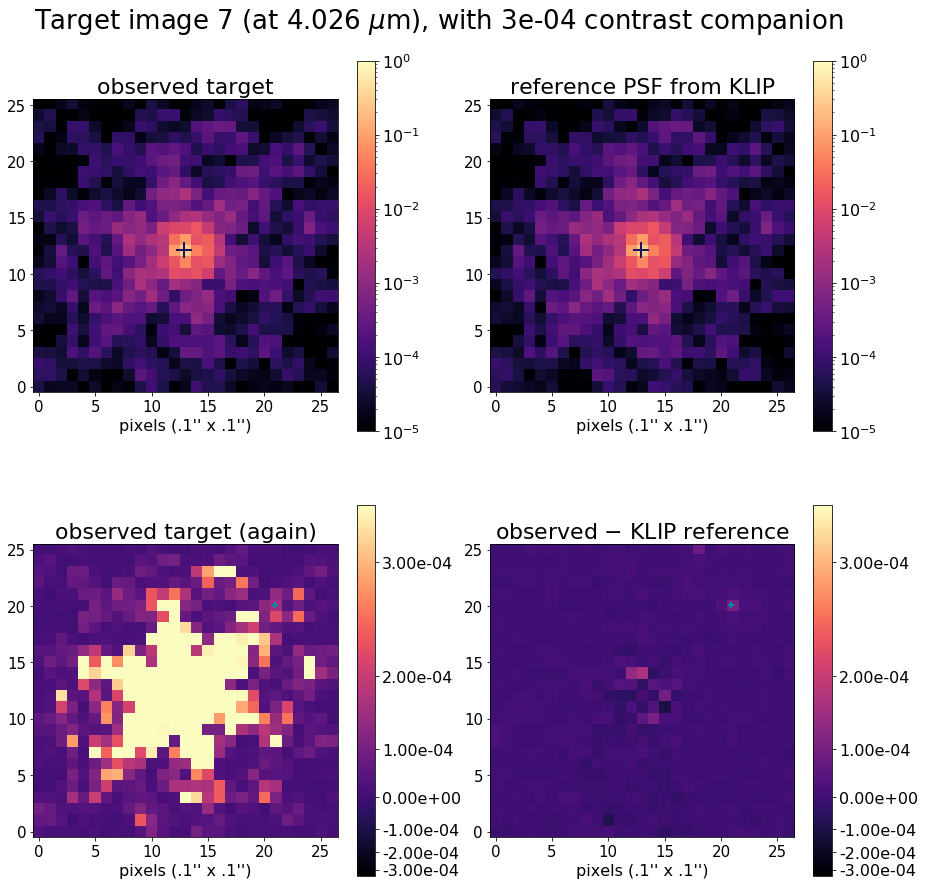

(0.9421401998154892, 0.004829993890216883)

In [ ]:
# examine pre and post-subtraction versions of one slice of one injected image
kr_full0.plot_subtraction(companion=True, target_image=7, wv_slice=1738)


********
1 arcsecond contrast @2.87 microns
pre-sub:  4.9792e-03 | post-sub: 2.7500e-04
********

********
1 arcsecond contrast @4.03 microns
pre-sub:  6.0136e-03 | post-sub: 3.2586e-04
********

********
1 arcsecond contrast @5.27 microns
pre-sub:  4.7199e-03 | post-sub: 9.4884e-05
********


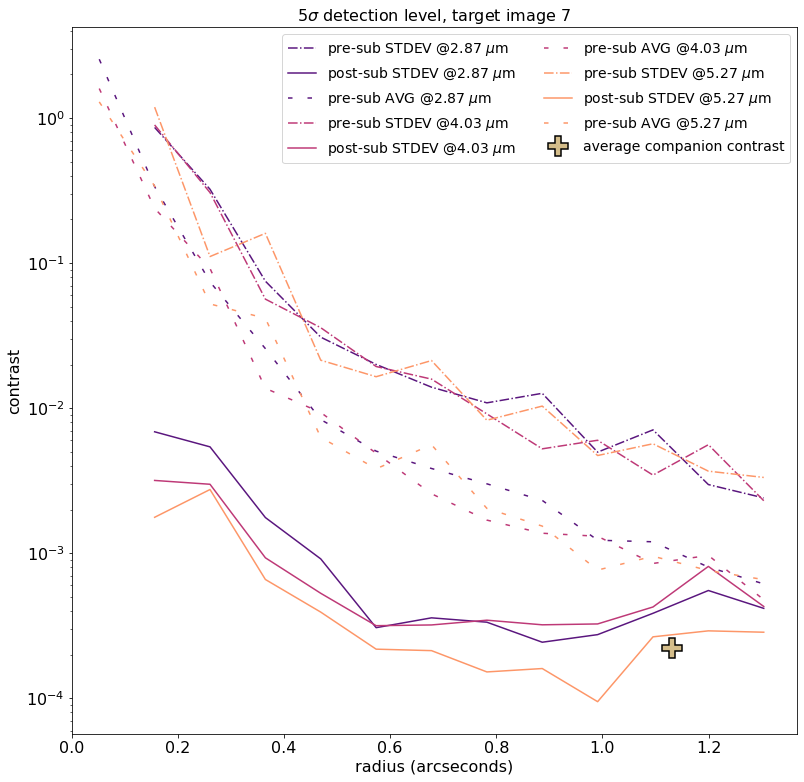

In [ ]:
kr_full0.plot_contrasts(target_image=7, times_sigma=5,
                        wv_slices=[0, 1738, -1], companion=True)

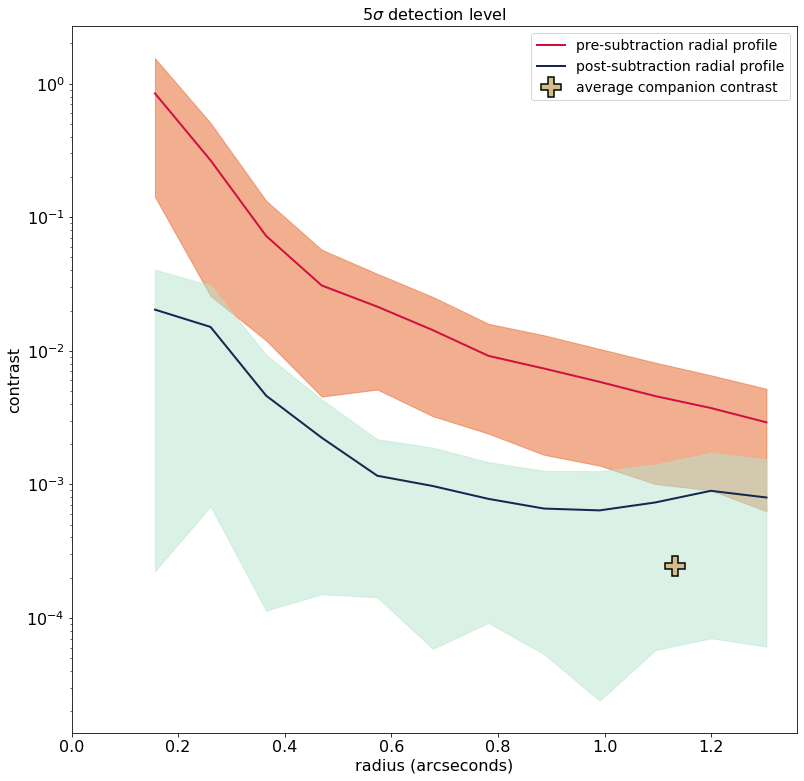

In [ ]:
kr_full0.plot_contrasts_avg(times_sigma=5, companion=True)

# Export the subtracted data cubes to their own directory.

Once that's through, you're one function call away from exporting your results.

In [ ]:
sub_dir_path = parent_dir(kr_full0.dir_name) + 'sub_kappa_all_slices0'

start = time.time()

# provide the HDUList of cubes to be subtracted by the KLIP projections as the argument
kr_full0.export_subtracted_cubes(sub_dir_path)

print(f"{(time.time() - start) / 60:02.0f}:{(time.time() - start) % 60:06.3f}")

00:11.813


You can then use DS9 to look at each subtracted data cube in your new directory. Any file whose name matches the pattern `sci_image*.fits` (where the asterisk is some number) will be a subtracted data cube.